In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import os
import pandas
import matplotlib
import torch

from torch import nn
from matplotlib import pyplot
from scipy.signal import windows

PATH = "../../results"


def calc_shape(shape, layers):
    """
    Calculates the shape of the tensor after the layers
    :param shape: A `tuple` of the input shape
    :param layers: A `list`-like of layers
    :returns : A `tuple` of the output shape
    """
    _shape = numpy.array(shape[1:])
    for layer in layers:
        _shape = (_shape + 2 * numpy.array(layer.padding) - numpy.array(layer.dilation) * (numpy.array(layer.kernel_size) - 1) - 1) / numpy.array(layer.stride) + 1
        _shape = _shape.astype(int)
    return (shape[0], *_shape)

class Policy(nn.Module):
    def __init__(
        self, in_channels=1, action_size=1, obs_size=(1, 64, 64),
        activation=nn.functional.leaky_relu
    ):
        self.in_channels = in_channels
        self.action_size = action_size
        self.obs_size = obs_size
        self.activation = activation
        super(Policy, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, 16, 8, stride=4),
            nn.Conv2d(16, 32, 4, stride=2),
        ])
        out_shape = calc_shape(obs_size, self.layers)
        self.linear = nn.Linear(32 * numpy.prod(out_shape), action_size)
        self.policy =  pfrl.policies.GaussianHeadWithStateIndependentCovariance(
            action_size=action_size,
            var_type="diagonal",
            var_func=lambda x: torch.exp(2 * x),  # Parameterize log std
            var_param_init=0,  # log std = 0 => std = 1
        )
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.policy(x)
        return x
class ValueFunction(nn.Module):
    def __init__(
        self, in_channels=1, action_size=1, obs_size=(1, 64, 64),
        activation=torch.tanh
    ):
        self.in_channels = in_channels
        self.action_size = action_size
        self.obs_size = obs_size
        self.activation = activation
        super(ValueFunction, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, 16, 8, stride=4),
            nn.Conv2d(16, 32, 4, stride=2),
        ])
        out_shape = calc_shape(obs_size, self.layers)
        self.linears = nn.ModuleList([
            nn.Linear(32 * numpy.prod(out_shape), 64),
            nn.Linear(64, action_size)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = x.view(x.size(0), -1)
        for layer in self.linears:
            x = self.activation(layer(x))
        return x

def sliding_window(x, kernel_size):
    """
    Computes a sliding window average over the specified data
    
    :param x: A `numpy.ndarray` of the data
    :param kernel_size: An `int` of the size of the sliding window
    
    :returns : A `numpy.ndarray` of the averaged data
    """
    if kernel_size < 2:
        return x
    window = windows.boxcar(kernel_size)
    window = window / window.sum()
    _x = numpy.pad(x, (kernel_size, kernel_size), mode="edge")
    return numpy.convolve(_x, window, mode="same")[kernel_size : -kernel_size]

def plot_score(df, x, y, shade_keys=None, smooth=1):
    """
    Plots the scores from a `pandas.DataFrame` using the provided 
    key
    
    :param df: A `pandas.DataFrame`
    :param key: A `str` of the desired key
    :param shade_keys: A `list` of keys to use as shade
    :param xlabel:
    
    :returns : A `matplotlib.Figure` of the created plot
               A `matplotlib.Axes` of the create plot
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.plot(df[x], sliding_window(df[y], smooth))
    if isinstance(shade_keys, (tuple, list)):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys[0]], smooth), 
            sliding_window(df[y] + df[shade_keys[1]], smooth), 
            alpha=0.3
        )
    elif isinstance(shade_keys, str):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys], smooth), 
            sliding_window(df[y] + df[shade_keys], smooth), 
            alpha=0.3
        )
    ax.set(
        xlabel=x, ylabel=y
    )
    return fig, ax

def savefig(fig, ax, savepath, extension="pdf", save_white=False):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        change_figax_color(fig, ax)
        fig.savefig(f"{savepath}_white.{extension}", bbox_inches="tight", transparent=True)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            collection.set_facecolors(new_colors)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()]   
            collection.set_edgecolors(new_colors)

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)

# Run model

In [24]:
import gym
import json
import os
import gym_sted
import pfrl
import torch
import sys
import pandas
import random
import pickle

from tqdm import trange, tqdm
from matplotlib import pyplot
from collections import defaultdict

while "../.." in sys.path:
    sys.path.remove("../..")
sys.path.insert(0, "../..")
from src import models, WrapPyTorch

from gym_sted.envs.sted_env import action_spaces, scales_dict, bounds_dict

PATH = "../../data"
model_name = "20210825-074335_f64f9d2b"
os.makedirs(os.path.join(PATH, model_name, "panels"), exist_ok=True)
os.makedirs(os.path.join(PATH, model_name, "eval"), exist_ok=True)

args = json.load(open(os.path.join(PATH, model_name, "args.txt"), "r"))
print(args)
def make_env(test):
    # Use different random seeds for train and test envs
    env_seed = 42
    env = gym.make(args["env"])
    # Use different random seeds for train and test envs
    env.seed(env_seed)
    # Converts the openAI Gym to PyTorch tensor shape
    env = WrapPyTorch(env)
    # Normalize the action space
    env = pfrl.wrappers.NormalizeActionSpace(env)
    return env

env = make_env(True)
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space

policy = models.RecurrentPolicy(action_size=action_space.shape[0], obs_space=obs_space)
vf = models.RecurrentValueFunction(obs_space=obs_space)
model = pfrl.nn.RecurrentBranched(policy, vf)

opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

agent = pfrl.agents.PPO(
    model,
    opt,
    gpu=None,
    minibatch_size=args["batchsize"],
    max_grad_norm=1.0,
    update_interval=512,
    recurrent=True
)
agent.load(os.path.join(PATH, model_name, "best"))

print(agent)

{'env': 'gym_sted:MOSTEDranking-easy-v2', 'num_envs': 25, 'seed': 0, 'gpu': 0, 'outdir': './data', 'exp_id': '20210825-074335', 'batchsize': 32, 'steps': 100000, 'eval_interval': 1000.0, 'eval_n_runs': 100, 'checkpoint_freq': 1000, 'reward_scale_factor': 1.0, 'render': False, 'lr': 0.0001, 'demo': False, 'load': '', 'log_level': 20, 'monitor': False, 'bleach_sampling': 'constant', 'recurrent': True}


/opt/anaconda3/envs/gym-sted/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


,steps,episodes,elapsed,mean,median,stdev,max,min,average_value,average_entropy,average_value_loss,average_policy_loss,n_updates,explained_variance
0,1000,100,860.662572,1.604,1.6,0.270398,2.0,1.2,0.387484,5.678646,0.245353,-0.012305,160,-0.003430
1,2000,200,1722.459259,1.591,1.6,0.274173,2.0,1.2,0.666929,5.674838,0.220839,-0.012484,480,-0.224003
2,3000,300,2588.659252,1.642,1.7,0.265216,2.0,1.2,0.631828,5.669067,0.161247,-0.003349,800,0.032390
3,4000,400,3453.767757,1.601,1.6,0.257609,2.0,1.2,0.639202,5.671265,0.117192,-0.014003,1120,0.146780
4,5000,500,4323.249048,1.579,1.6,0.258705,2.0,1.2,0.655759,5.663659,0.103689,-0.022507,1440,0.276404


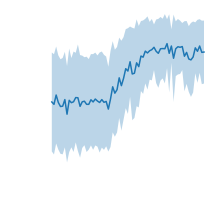

In [25]:
df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
display(df.head())

smoothing_factor = 0
fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
savefig(fig, ax, os.path.join(PATH, model_name, "panels", "mean_reward"), save_white=True)

pyplot.show()

In [26]:
phy_reacts = {
    "low-bleach" : gym_sted.defaults.FLUO["phy_react"],
    "mid-bleach" : {488: 0.5e-7 + 3 * 0.25e-7, 575: 50.0e-11 + 3 * 25.0e-11},
    "high-bleach" : {488: 0.5e-7 + 10 * 0.25e-7, 575: 50.0e-11 + 10 * 25.0e-11},
}
episode_count = 10
render, done = False, False

episode_stats = defaultdict(list)
for key, phy_react in phy_reacts.items():
    with agent.eval_mode():
        for i in trange(episode_count, desc="key", leave=False):
            observation = env.reset()

            # Sets the microscope bleach constant to default values
            env.microscope.fluo.phy_react = phy_react
    #         env.synapse_generator = gym_sted.utils.SynapseGenerator(mode="rand", seed=None, molecules=1)
    #         env.microscope.fluo.phy_react = {
    #             488: 0.5e-7 + 3 * 0.25e-7,
    #             575: 50.0e-11 + 3 * 25.0e-11
    #         }

            timestep, episode_len, cum_rewards = 0, 0, 0
            max_episode_len = env.spec.max_episode_steps

            stats = defaultdict(list)        
            while True:
                action = agent.act(observation)

                observation, reward, done, info = env.step(action)
                reset = done or episode_len == max_episode_len or info.get("needs_reset", False)
                agent.observe(observation, reward, done, reset)

                stats["reward"].append(reward)
                stats["info"].append(info)

                if render:
                    env.render(info)
                if done:
                    break

                episode_len += 1

            episode_stats[key].append(stats)

In [27]:
pickle.dump(episode_stats, open(os.path.join(PATH, model_name, "eval", "stats.pkl"), "wb"))

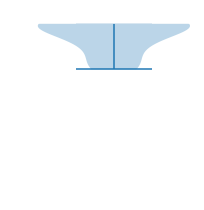

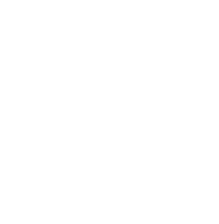

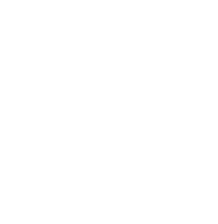

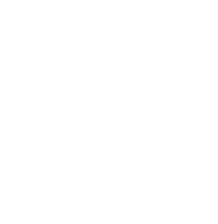

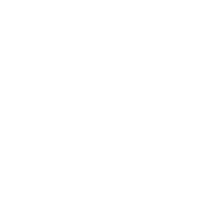

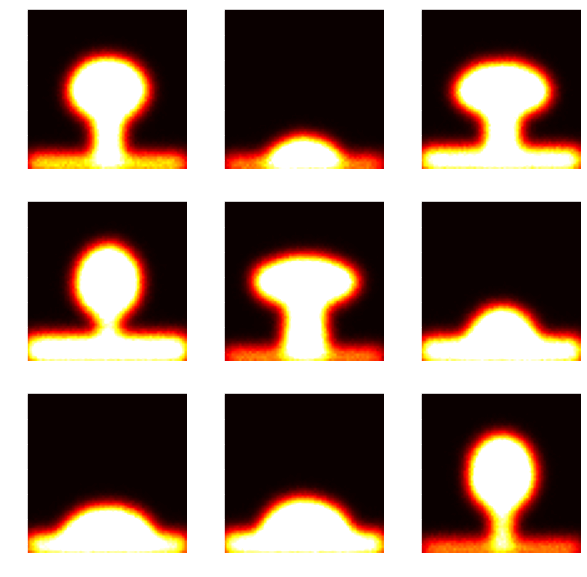

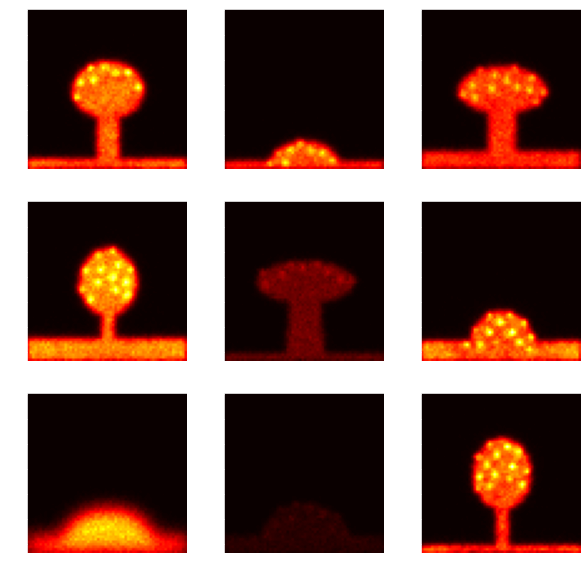

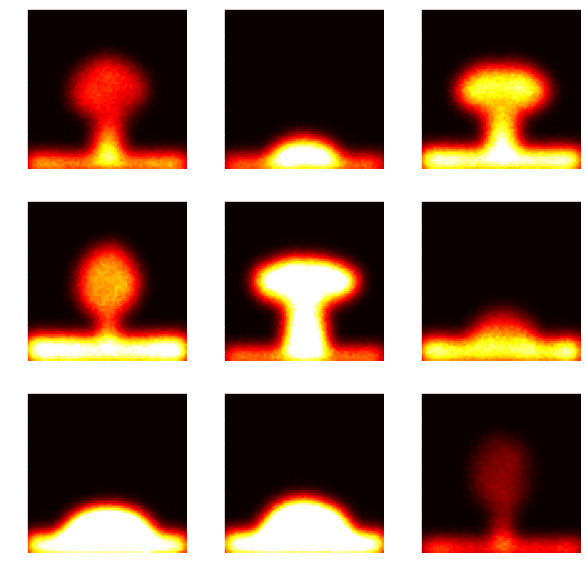

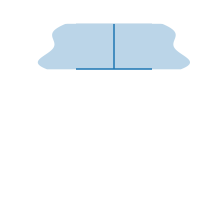

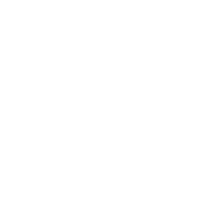

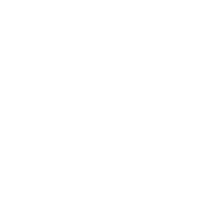

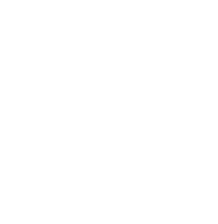

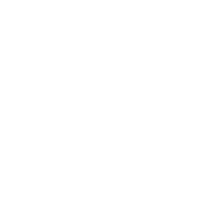

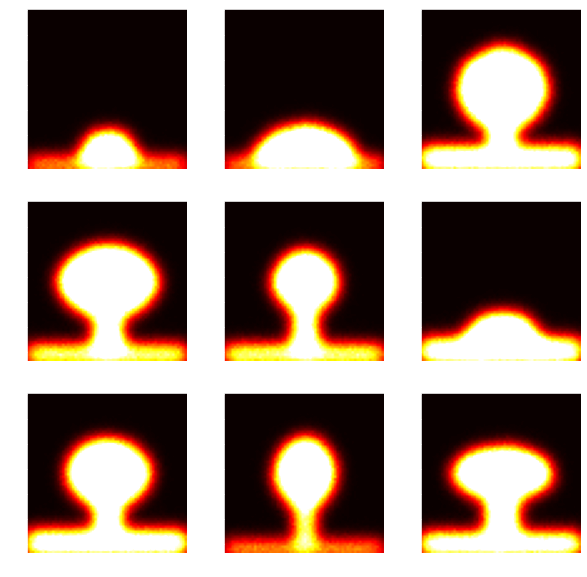

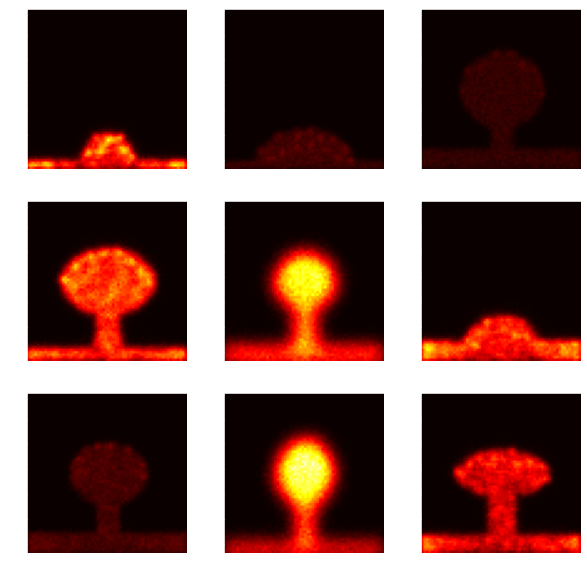

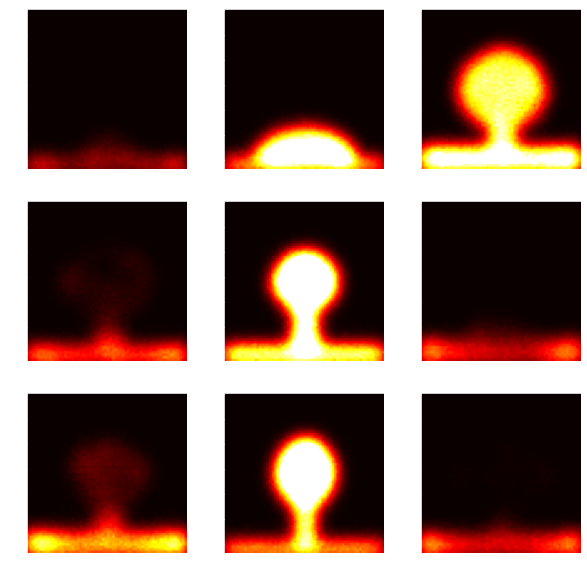

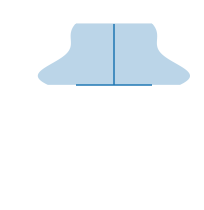

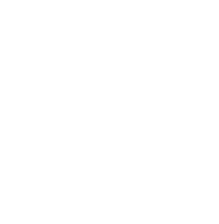

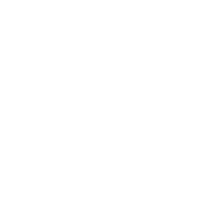

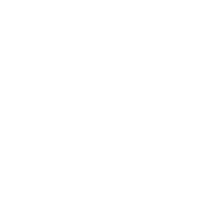

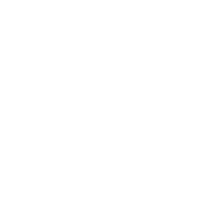

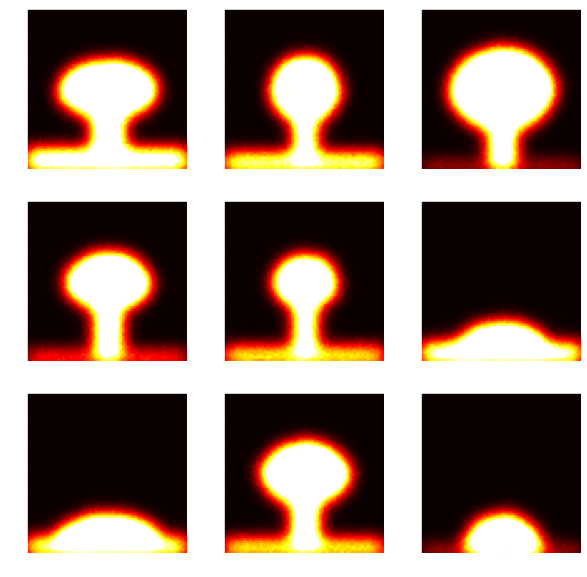

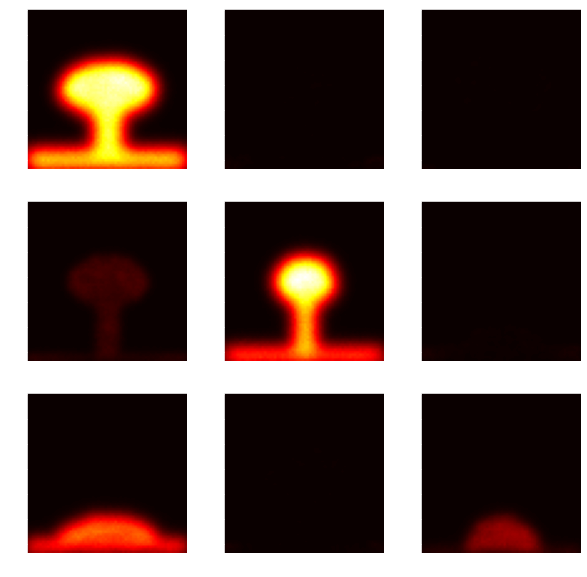

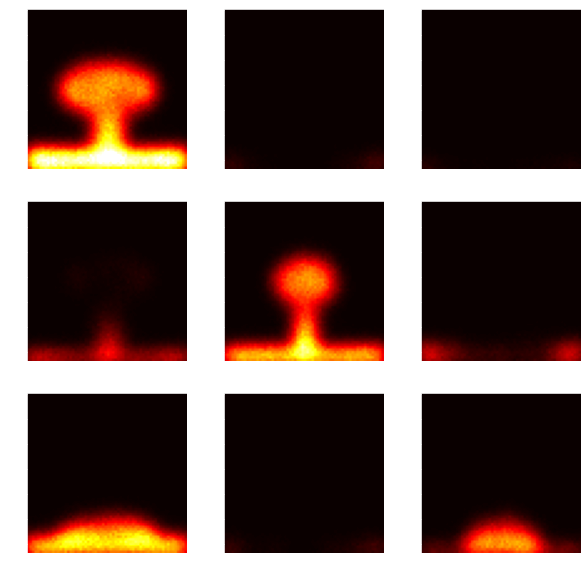

In [28]:
def plot_avg_reward(episode_stats):
    values = [sum(stats["reward"]) for stats in episode_stats]
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.violinplot(values)
    ax.set(
        ylim=(-0.1, max(1.1, max(values))), title="Average reward"
    )
    return fig, ax

def plot_avg_rewards(episode_stats):
    values = [stats["info"][0]["rewards"] for stats in episode_stats]
    values = numpy.array(values)    

    fig, ax = pyplot.subplots(figsize=(3,3))
    for i, (key, value) in enumerate(zip(env.obj_names, values.T)):    
        value = (value - scales_dict[key]["min"]) / (scales_dict[key]["max"] - scales_dict[key]["min"])
        ax.violinplot(value, positions=[i])
        bound = bounds_dict[key]["max"] if key != "SNR" else bounds_dict[key]["min"]
        bound = (bound - scales_dict[key]["min"]) / (scales_dict[key]["max"] - scales_dict[key]["min"])
        ax.scatter(i, bound, marker="_", s=50, color="black")
    ax.set(
        ylim=(0, 1), title="Objective", 
        xticks=(numpy.arange(values.shape[-1])), xticklabels=(env.obj_names)
    )
    return fig, ax
    
def plot_avg_action(episode_stats):
    values = [stats["info"][0]["action"] for stats in episode_stats]
    values = numpy.array(values)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for i, (key, value) in enumerate(zip(env.actions, values.T)):    
        value = (value - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
        ax.violinplot(value, positions=[i])
    ax.set(
        ylim=(0, 1), title="Actions",
        xticks=(numpy.arange(values.shape[-1])), xticklabels=(env.actions)        
    )
    return fig, ax

def plot_avg_multiaction(episode_stats):
    values = [numpy.array([step["action"] for step in stats["info"]]) for stats in episode_stats]

    out = {"imaging-action" : []}
    for i, key in enumerate(env.actions):
        fig, ax = pyplot.subplots(figsize=(3,3))
        for value in values:
            value = (value[:, i] - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            ax.plot(value, alpha=0.3, color="black", label=key)
            ax.scatter(len(value) - 1, value[-1], marker="*", color="black")
        ax.set(
            ylim=(0, 1), title="Imaging action",
            xlabel="Steps", ylabel=key
        )
        out["imaging-action"].append((fig, ax))
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for value in values:
        value = numpy.clip(value[:, -1].astype(int) - 1, 0, 2)
        index = numpy.argmax(value == 1)
        where = value == 1
        where[index] = False
        value[where] = 0
        value[-1] = 2
        ax.plot(value, color="black", alpha=0.3)
    ax.set(
        ylim=(0, 2), title="Main action",
        xlabel="Steps"
    )
    out["main-action"] = (fig, ax)    
    
    return out

def plot_last_image(episode_stats):
    """
    Plots the last acquired image across all episodes
    """
    out = {}
    
    images = [stats["info"][-1]["conf1"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)
    out["conf1"] = (fig, axes)
        
    images = [stats["info"][-1]["sted_image"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    vmax = max([img.max() for img in images])
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=vmax) 
    out["sted_image"] = (fig, axes)        
        
    images = [stats["info"][-1]["conf2"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)                
    out["conf2"] = (fig, axes)            
    return out               
    
for bleach in phy_reacts.keys():

    fig, ax = plot_avg_reward(episode_stats[bleach])
    savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_reward"), save_white=True)

    # fig, ax = plot_avg_rewards(episode_stats)
    # savefig(fig, ax, os.path.join(PATH, model_name, "panels", "avg_rewards"), save_white=True)

    # fig, ax = plot_avg_action(episode_stats)
    # savefig(fig, ax, os.path.join(PATH, model_name, "panels", "avg_action"), save_white=True)

    figaxes = plot_avg_multiaction(episode_stats[bleach])
    for key, figaxes in figaxes.items():
        if isinstance(figaxes, tuple):
            fig, ax = figaxes
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_multiaction_{key}"), save_white=True)
        else:
            for action_name, (fig, ax) in zip(env.actions, figaxes):
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_multiaction_{key}_{action_name}"), save_white=True)            

    figaxes = plot_last_image(episode_stats[bleach])
    for key, figaxes in figaxes.items():
        if isinstance(figaxes, tuple):
            fig, ax = figaxes
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}"), save_white=True)
        else:
            for action_name, (fig, ax) in zip(env.actions, figaxes):
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}_{action_name}"), save_white=True)                

    pyplot.show()
